# MODULE 4 PROJECT

KIMBERLY HUMPHREY

Time Series Analysis on Investment Potential of Realestate in Nevada County, CA by Zip Code

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss

## Cleaning

In [6]:
df = pd.read_csv('zillow_data.csv')

In [7]:
df = df[df['CountyName'] == 'Nevada']
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2816,98497,95945,Grass Valley,CA,Truckee,Nevada,2817,145300.0,143900.0,142400.0,...,333900,336900,340300,342200,343800,347200,350600,354500,360200,364900
4889,98510,95959,Nevada City,CA,Truckee,Nevada,4890,158100.0,156500.0,155000.0,...,392300,396100,401800,405500,407600,411600,416000,419400,422600,424800
5361,98501,95949,Grass Valley,CA,Truckee,Nevada,5362,171900.0,170300.0,168700.0,...,382000,385300,389300,391900,394700,397400,400900,405000,410000,412600
6498,98672,96161,Truckee,CA,Truckee,Nevada,6499,199700.0,197400.0,195100.0,...,594100,597300,599700,601800,603100,605500,608100,609800,612600,615900
7523,98498,95946,Penn Valley,CA,Truckee,Nevada,7524,183900.0,181800.0,179900.0,...,353500,356500,359700,363900,368100,371400,373500,377300,383800,389100


In [8]:
df.drop(['RegionID', 'State', 'Metro', 'CountyName'], axis=1, inplace=True)

In [9]:
df

,RegionName,City,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2816,95945,Grass Valley,2817,145300.0,143900.0,142400.0,141100.0,139800.0,138800.0,138000.0,...,333900,336900,340300,342200,343800,347200,350600,354500,360200,364900
4889,95959,Nevada City,4890,158100.0,156500.0,155000.0,153600.0,152300.0,151200.0,150500.0,...,392300,396100,401800,405500,407600,411600,416000,419400,422600,424800
5361,95949,Grass Valley,5362,171900.0,170300.0,168700.0,167100.0,165600.0,164300.0,163100.0,...,382000,385300,389300,391900,394700,397400,400900,405000,410000,412600
6498,96161,Truckee,6499,199700.0,197400.0,195100.0,192900.0,190800.0,188500.0,186200.0,...,594100,597300,599700,601800,603100,605500,608100,609800,612600,615900
7523,95946,Penn Valley,7524,183900.0,181800.0,179900.0,178300.0,176800.0,175700.0,174800.0,...,353500,356500,359700,363900,368100,371400,373500,377300,383800,389100
13518,95975,Rough and Ready,13519,163600.0,162500.0,161300.0,160000.0,158800.0,157600.0,156500.0,...,368300,371900,375400,377300,377900,379300,381400,387000,395400,400800
13914,95977,Smartsville,13915,145700.0,145500.0,145300.0,145100.0,144900.0,144800.0,144900.0,...,328100,335900,341600,341900,339400,339200,341500,345900,350700,352300
14690,95728,Truckee,14691,147700.0,147800.0,148100.0,148400.0,148800.0,149300.0,149900.0,...,476900,488600,494100,491200,485700,482600,480900,483600,490500,496300


## Preprocessing

In [10]:
melt = pd.melt(df, id_vars=['RegionName', 'City', 'SizeRank'])
melt

,RegionName,City,SizeRank,variable,value
0,95945,Grass Valley,2817,1996-04,145300.0
1,95959,Nevada City,4890,1996-04,158100.0
2,95949,Grass Valley,5362,1996-04,171900.0
3,96161,Truckee,6499,1996-04,199700.0
4,95946,Penn Valley,7524,1996-04,183900.0
...,...,...,...,...,...
2115,96161,Truckee,6499,2018-04,615900.0
2116,95946,Penn Valley,7524,2018-04,389100.0
2117,95975,Rough and Ready,13519,2018-04,400800.0
2118,95977,Smartsville,13915,2018-04,352300.0


In [11]:
melt['variable'] = pd.to_datetime(melt['variable'], format='%Y-%m')
melt

,RegionName,City,SizeRank,variable,value
0,95945,Grass Valley,2817,1996-04-01,145300.0
1,95959,Nevada City,4890,1996-04-01,158100.0
2,95949,Grass Valley,5362,1996-04-01,171900.0
3,96161,Truckee,6499,1996-04-01,199700.0
4,95946,Penn Valley,7524,1996-04-01,183900.0
...,...,...,...,...,...
2115,96161,Truckee,6499,2018-04-01,615900.0
2116,95946,Penn Valley,7524,2018-04-01,389100.0
2117,95975,Rough and Ready,13519,2018-04-01,400800.0
2118,95977,Smartsville,13915,2018-04-01,352300.0


In [12]:
melt.rename(columns={'variable':'Date', 'RegionName':'ZipCode', 'value':'Value'}, inplace=True)

In [13]:
melt.set_index(['Date'], inplace=True, drop=True)

In [14]:
melt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2120 entries, 1996-04-01 to 2018-04-01
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ZipCode   2120 non-null   int64  
 1   City      2120 non-null   object 
 2   SizeRank  2120 non-null   int64  
 3   Value     2120 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 82.8+ KB


In [15]:
#How many unique zip codes are there in CA? 1224
melt.ZipCode.unique()

array([95945, 95959, 95949, 96161, 95946, 95975, 95977, 95728],
      dtype=int64)

In [149]:
zip_95945 = melt[melt['ZipCode'] == 95945]
zip_95959 = melt[melt['ZipCode'] == 95959]
zip_95949 = melt[melt['ZipCode'] == 95949]
zip_96161 = melt[melt['ZipCode'] == 96161]
zip_95946 = melt[melt['ZipCode'] == 95946]
zip_95975 = melt[melt['ZipCode'] == 95975]
zip_95977 = melt[melt['ZipCode'] == 95977]
zip_95728 = melt[melt['ZipCode'] == 95728]

In [150]:
zip_dfs = [zip_95945, zip_95959, zip_95949, zip_96161, zip_95946, zip_95975, zip_95977, zip_95728]
zips = melt.ZipCode.unique()

In [151]:
zip_95945

,ZipCode,City,SizeRank,Value
Date,,,,
1996-04-01,95945,Grass Valley,2817,145300.0
1996-05-01,95945,Grass Valley,2817,143900.0
1996-06-01,95945,Grass Valley,2817,142400.0
1996-07-01,95945,Grass Valley,2817,141100.0
1996-08-01,95945,Grass Valley,2817,139800.0
...,...,...,...,...
2017-12-01,95945,Grass Valley,2817,347200.0
2018-01-01,95945,Grass Valley,2817,350600.0
2018-02-01,95945,Grass Valley,2817,354500.0


In [152]:
for x in zip_dfs:
    x.drop(columns=['SizeRank', 'ZipCode', 'City'], axis=1, inplace=True)
    

In [168]:
zipped = zip(zip_dfs, zips)

## Visualizing

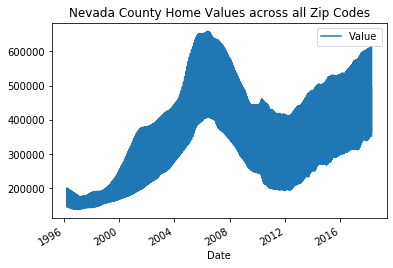

In [336]:
melt['Value'].plot(legend=True)
plt.title('Nevada County Home Values across all Zip Codes')
plt.legend();

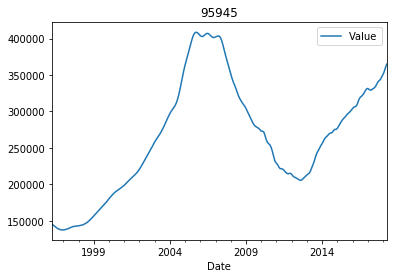

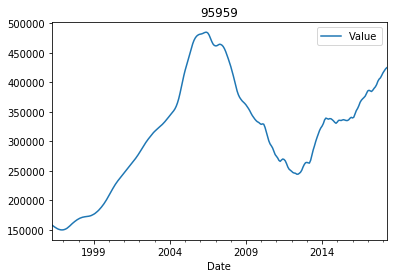

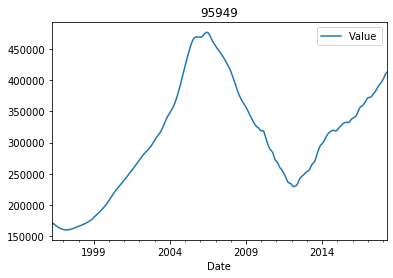

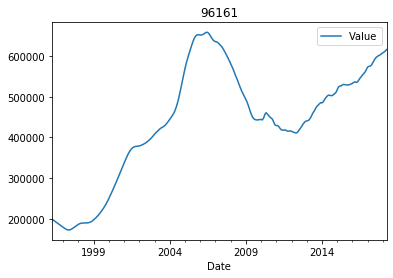

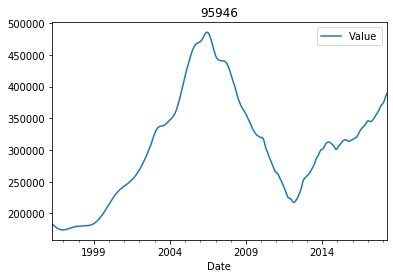

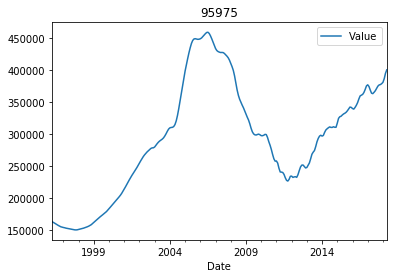

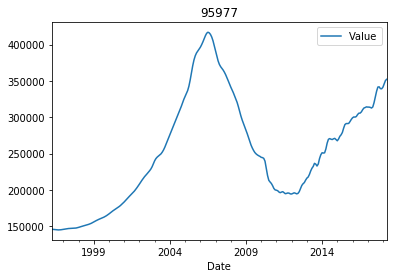

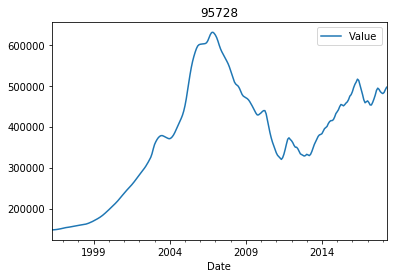

In [174]:
for x, y in zip(zip_dfs, zips):
    x.plot()
    plt.title(y)

## Statistics

In [175]:
for x, y in zip(zip_dfs, zips):
    print(y)
    print(f'Max: {x.Value.max()}')
    print(f'Min: {x.Value.min()}')
    print(f'Mean: {round(x.Value.mean())}')
    print(f'Max ROI: {round(((x.Value.max() / x.Value.min()) * 100))}')
    print(f'Current Difference from Max: -{(x.Value.max() - x.Value[-1])}')
    print(f'Percent Gain since 2012: {round((x.Value[-1] / x.Value[-76]) * 100)}')

95945
Max: 408600.0
Min: 137300.0
Mean: 264065.0
Max ROI: 298.0
Current Difference from Max: -43700.0
Percent Gain since 2012: 171.0
95959
Max: 484900.0
Min: 149900.0
Mean: 313348.0
Max ROI: 323.0
Current Difference from Max: -60100.0
Percent Gain since 2012: 170.0
95949
Max: 476800.0
Min: 160100.0
Mean: 306469.0
Max ROI: 298.0
Current Difference from Max: -64200.0
Percent Gain since 2012: 177.0
96161
Max: 658500.0
Min: 172900.0
Mean: 438822.0
Max ROI: 381.0
Current Difference from Max: -42600.0
Percent Gain since 2012: 148.0
95946
Max: 485700.0
Min: 173900.0
Mean: 304885.0
Max ROI: 279.0
Current Difference from Max: -96600.0
Percent Gain since 2012: 176.0
95975
Max: 459700.0
Min: 150600.0
Mean: 292547.0
Max ROI: 305.0
Current Difference from Max: -58900.0
Percent Gain since 2012: 171.0
95977
Max: 417100.0
Min: 144800.0
Mean: 252171.0
Max ROI: 288.0
Current Difference from Max: -64800.0
Percent Gain since 2012: 181.0
95728
Max: 630700.0
Min: 147700.0
Mean: 374641.0
Max ROI: 427.0
Curre

## Manually Detrending

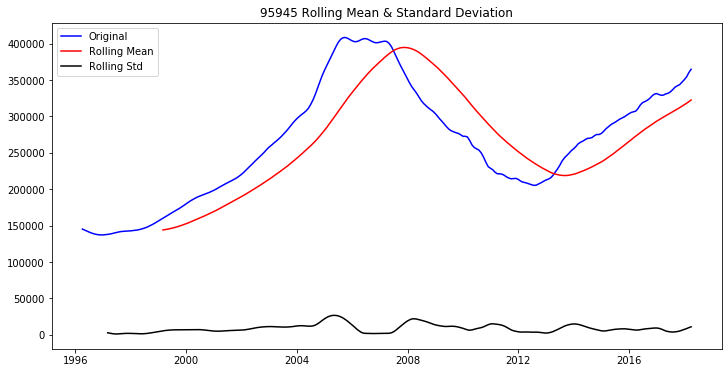

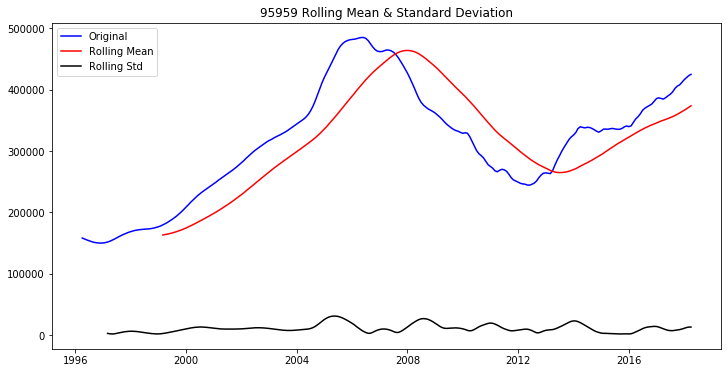

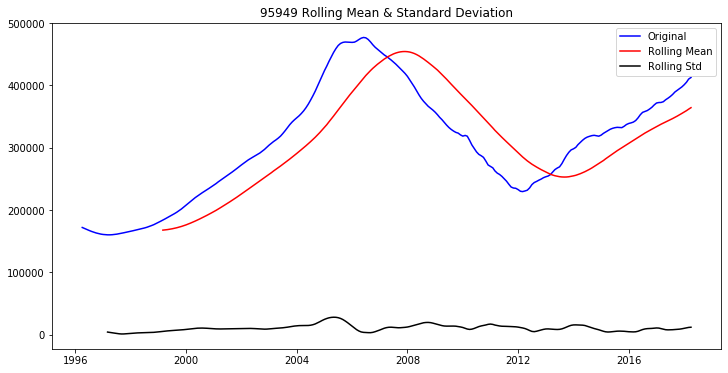

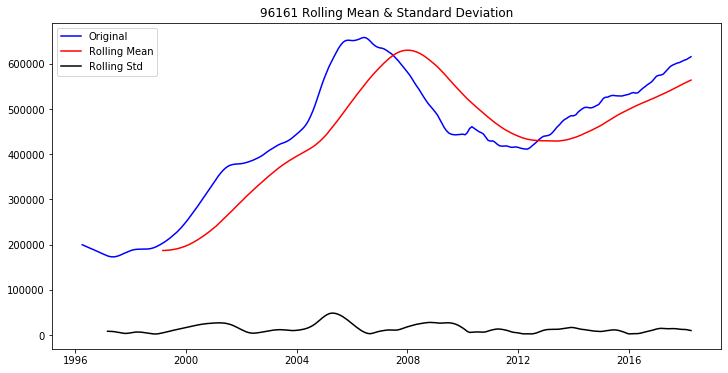

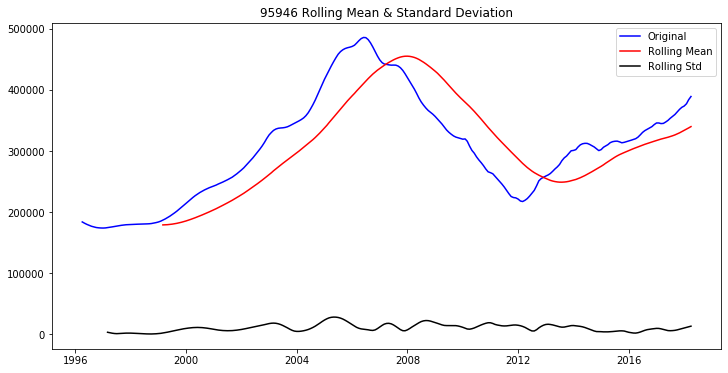

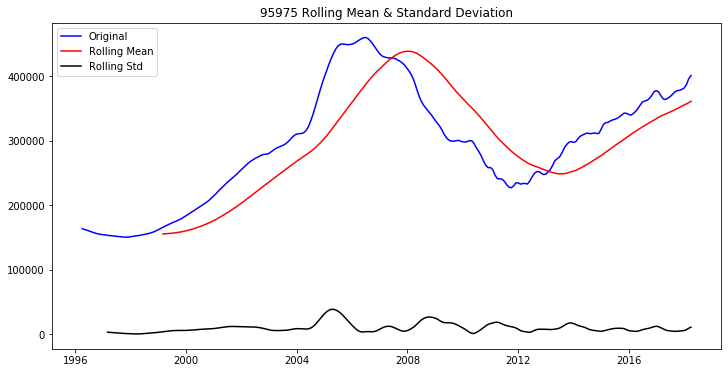

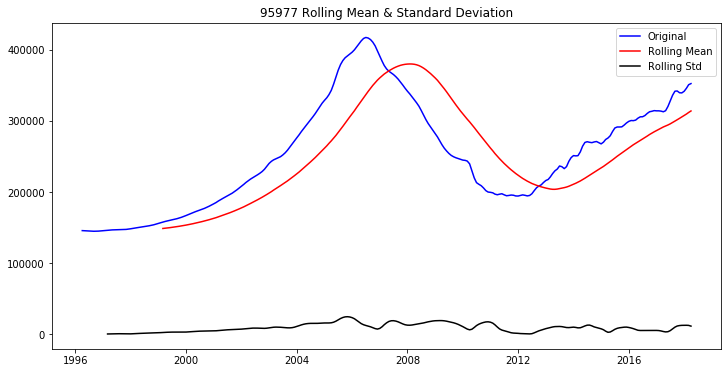

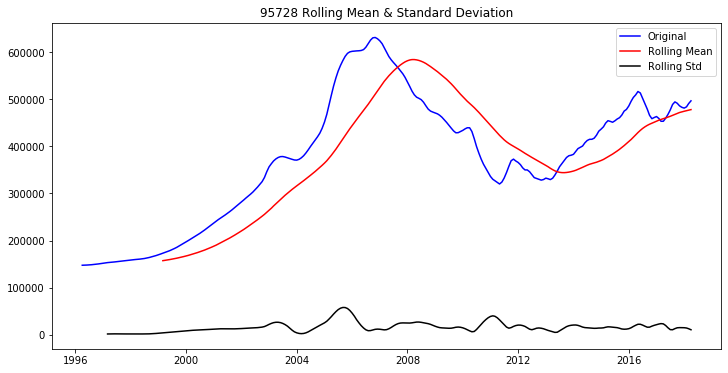

In [184]:
for x,y in zip(zip_dfs, zips):
# Rolling statistics
    roll_mean = x.rolling(window=36, center=False).mean()
    roll_std = x.rolling(window=12, center=False).std()
# Plot rolling statistics
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'{y} Rolling Mean & Standard Deviation')
    plt.show();

In [162]:
def dickey_fuller(df, title):
# Perform Dickey-Fuller test:
    print (f'Results of Dickey-Fuller Test: {title} \n')
    dftest = adfuller(df['Value'])

# Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(f'{dfoutput} \n')

In [157]:
for x, y in zip(zip_dfs, zips):
    dickey_fuller(x,y)

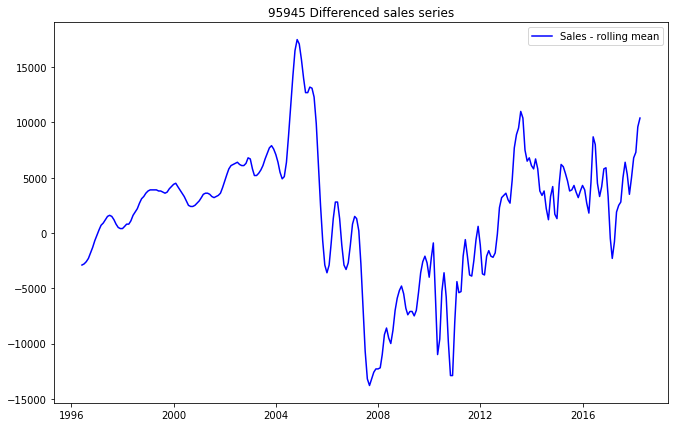

Results of Dickey-Fuller Test: 95945 

Test Statistic                  -1.294190
p-value                          0.631826
#Lags Used                      16.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64 



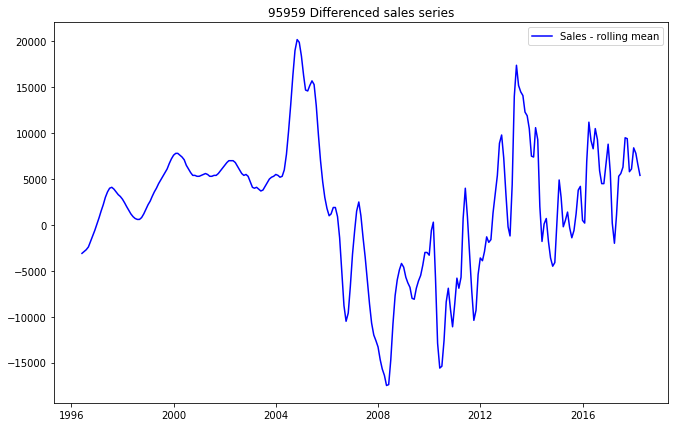

Results of Dickey-Fuller Test: 95959 

Test Statistic                  -2.224357
p-value                          0.197524
#Lags Used                      12.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64 



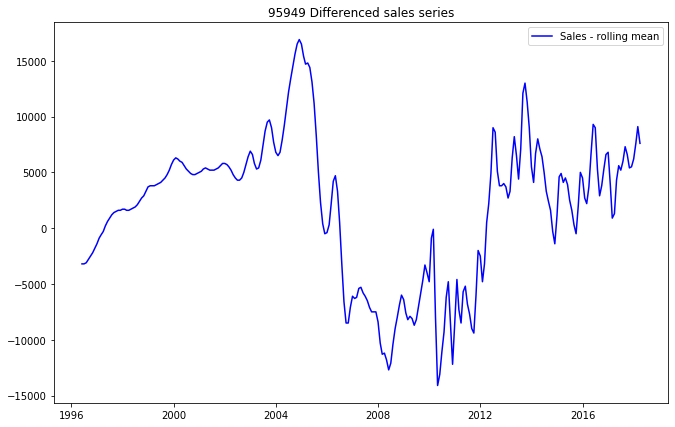

Results of Dickey-Fuller Test: 95949 

Test Statistic                  -2.254367
p-value                          0.187108
#Lags Used                      16.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64 



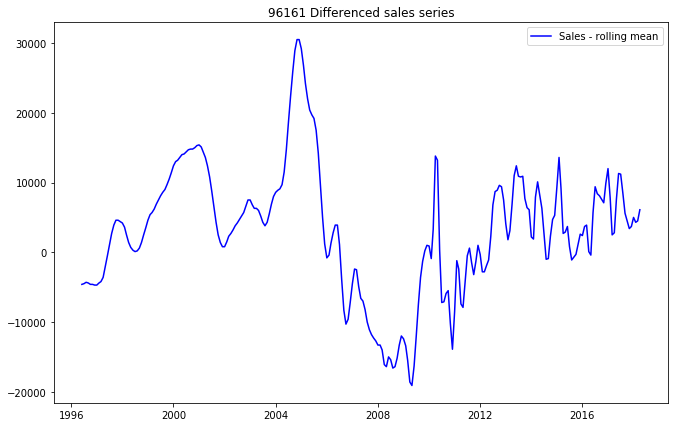

Results of Dickey-Fuller Test: 96161 

Test Statistic                  -2.236830
p-value                          0.193151
#Lags Used                      13.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64 



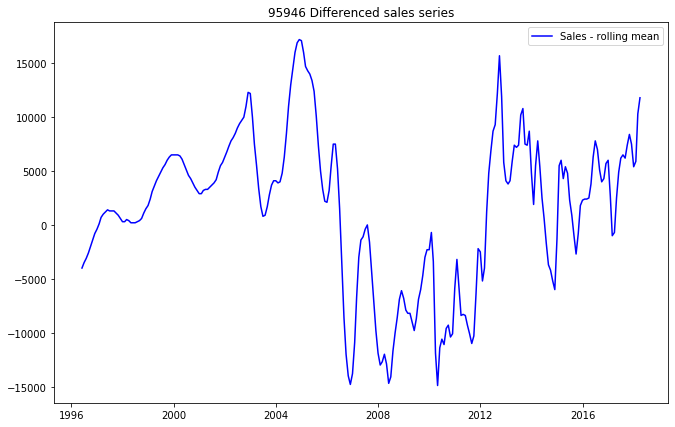

Results of Dickey-Fuller Test: 95946 

Test Statistic                  -2.444312
p-value                          0.129618
#Lags Used                       9.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64 



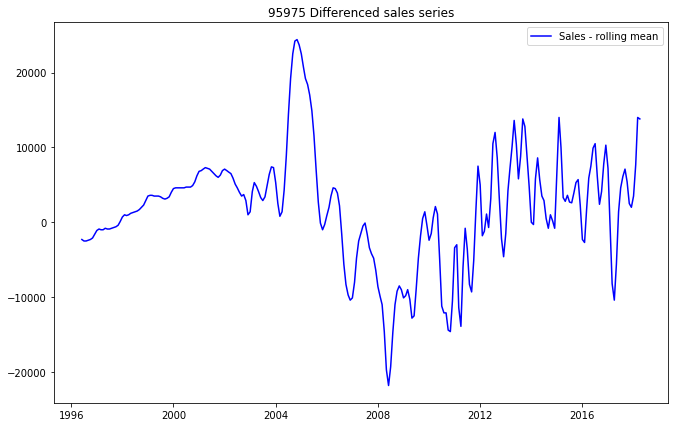

Results of Dickey-Fuller Test: 95975 

Test Statistic                  -2.129981
p-value                          0.232631
#Lags Used                      16.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64 



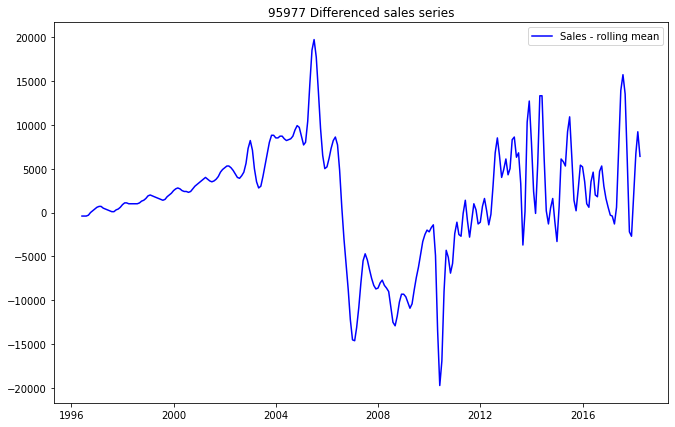

Results of Dickey-Fuller Test: 95977 

Test Statistic                  -2.147525
p-value                          0.225839
#Lags Used                       7.000000
Number of Observations Used    255.000000
Critical Value (1%)             -3.456257
Critical Value (5%)             -2.872942
Critical Value (10%)            -2.572846
dtype: float64 



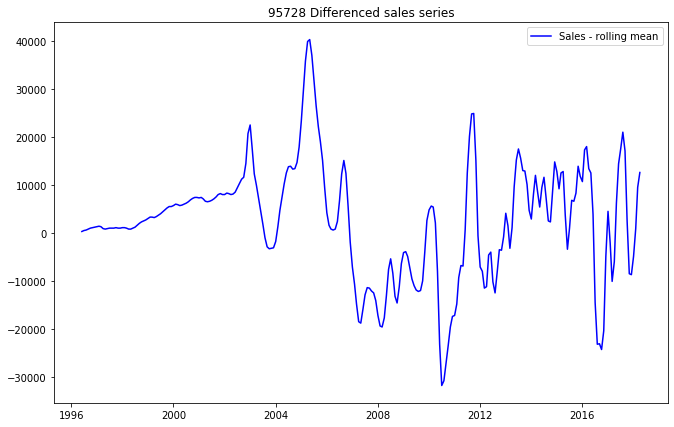

Results of Dickey-Fuller Test: 95728 

Test Statistic                  -2.548217
p-value                          0.104179
#Lags Used                      15.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64 



In [180]:
for x,y in zip(zip_dfs, zips):
    data_diff = x.diff(periods=2)
    data_diff.dropna(inplace=True)
    fig = plt.figure(figsize=(11,7))
    plt.plot(data_diff, color='blue',label='Sales - rolling mean')
    plt.legend(loc='best')
    plt.title(f'{y} Differenced sales series')
    plt.show(block=False)
    dickey_fuller(data_diff,y)

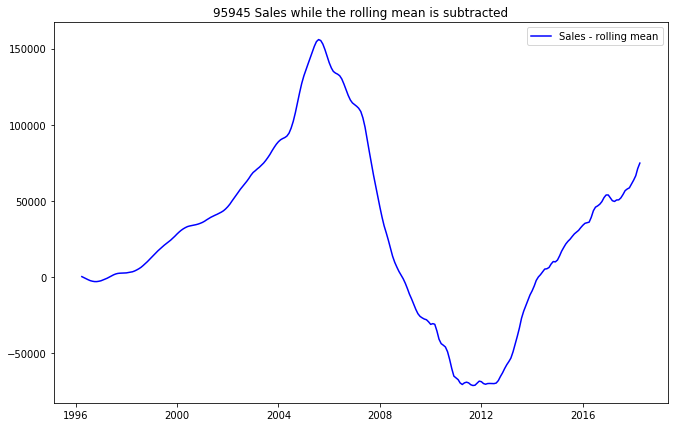

Results of Dickey-Fuller Test: 95945 

Test Statistic                  -2.812362
p-value                          0.056530
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64 



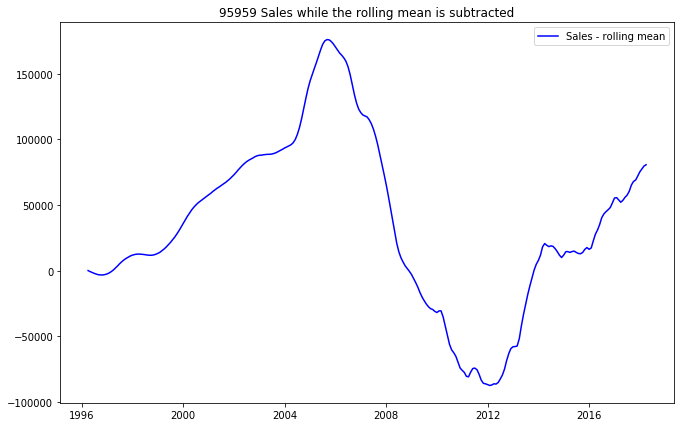

Results of Dickey-Fuller Test: 95959 

Test Statistic                  -2.211539
p-value                          0.202084
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64 



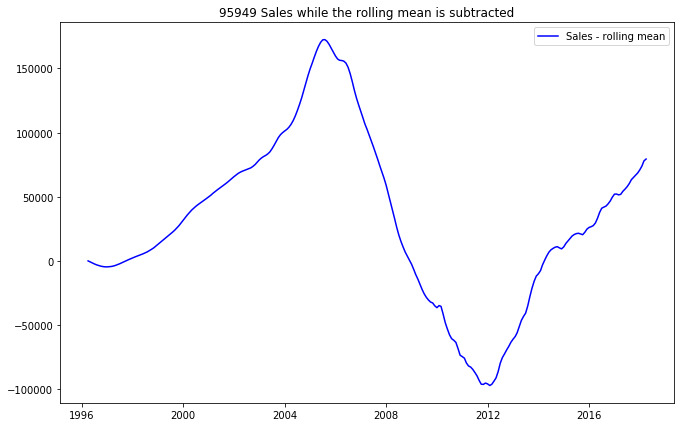

Results of Dickey-Fuller Test: 95949 

Test Statistic                  -2.524611
p-value                          0.109600
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64 



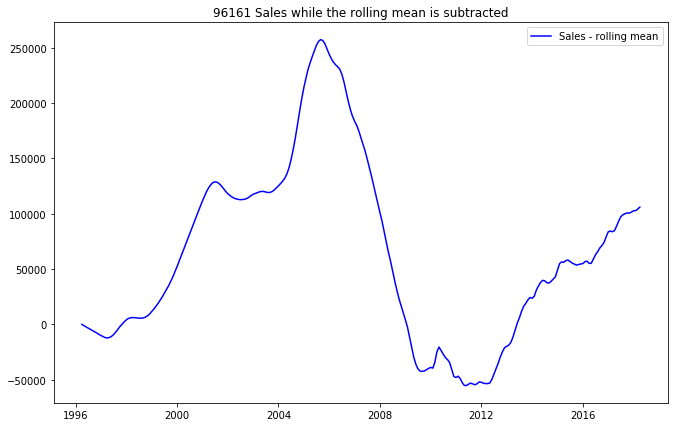

Results of Dickey-Fuller Test: 96161 

Test Statistic                  -2.596136
p-value                          0.093799
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64 



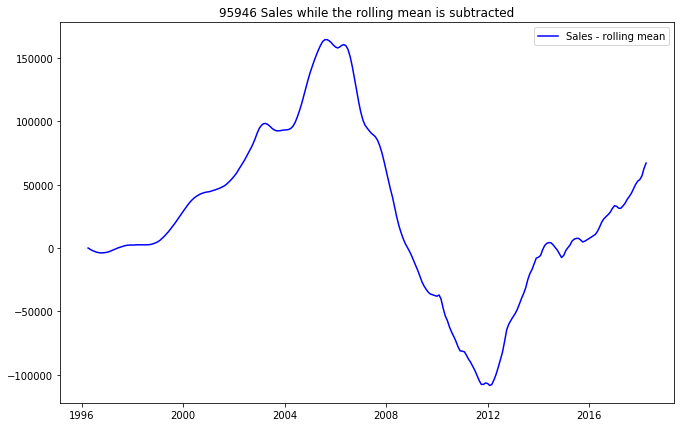

Results of Dickey-Fuller Test: 95946 

Test Statistic                  -2.384868
p-value                          0.146053
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64 



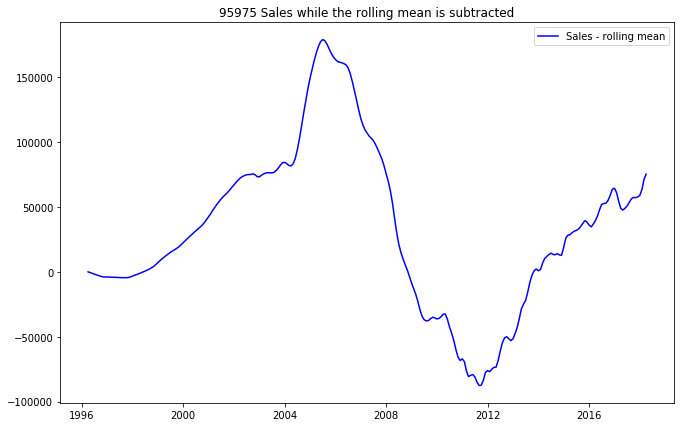

Results of Dickey-Fuller Test: 95975 

Test Statistic                  -2.644765
p-value                          0.084094
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64 



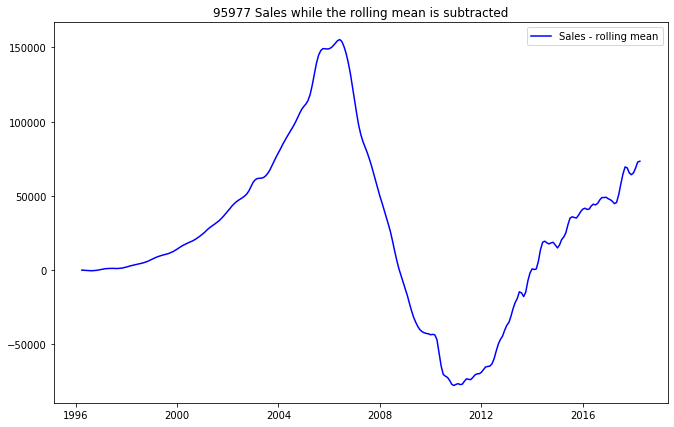

Results of Dickey-Fuller Test: 95977 

Test Statistic                  -3.276315
p-value                          0.015971
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64 



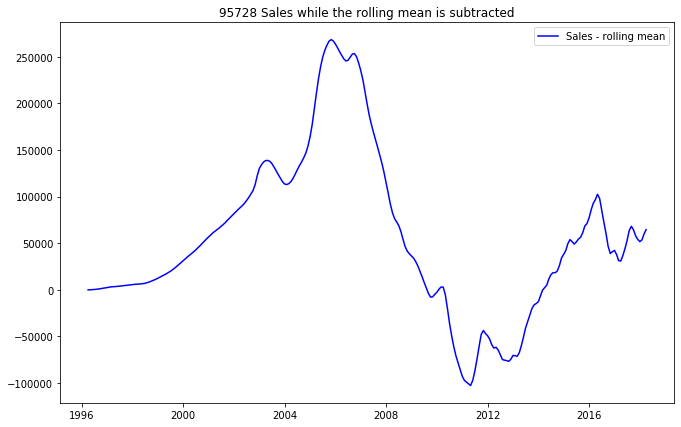

Results of Dickey-Fuller Test: 95728 

Test Statistic                  -2.165622
p-value                          0.218958
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64 



In [181]:
for x,y in zip(zip_dfs, zips):
    exp_roll_mean = x.ewm(halflife=50).mean()
    data_minus_exp_roll_mean = x - exp_roll_mean
    data_minus_exp_roll_mean.dropna(inplace=True)
    fig = plt.figure(figsize=(11,7))
    plt.plot(data_minus_exp_roll_mean, color='blue',label='Sales - rolling mean')
    plt.legend(loc='best')
    plt.title(f'{y} Sales while the rolling mean is subtracted')
    plt.show(block=False)
    dickey_fuller(data_minus_exp_roll_mean,y)

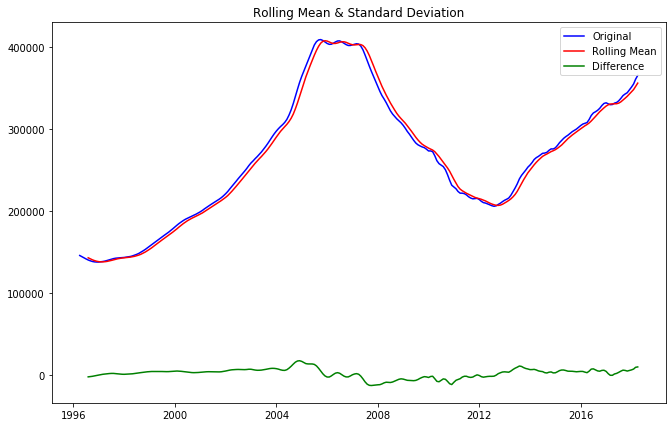

Results of Dickey-Fuller Test: 95945 

Test Statistic                  -4.112540
p-value                          0.000923
#Lags Used                      16.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64 



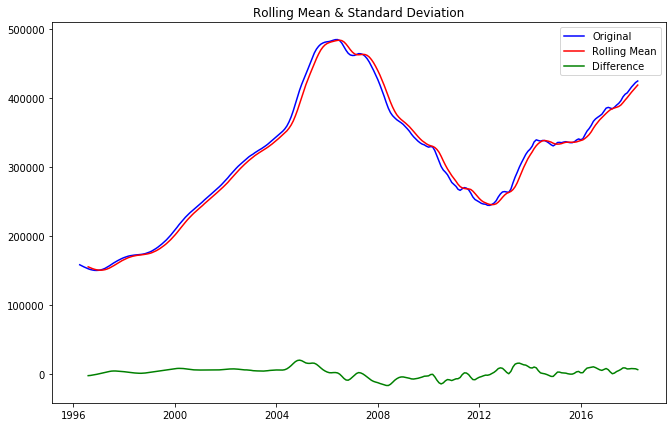

Results of Dickey-Fuller Test: 95959 

Test Statistic                  -4.688955
p-value                          0.000088
#Lags Used                      13.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64 



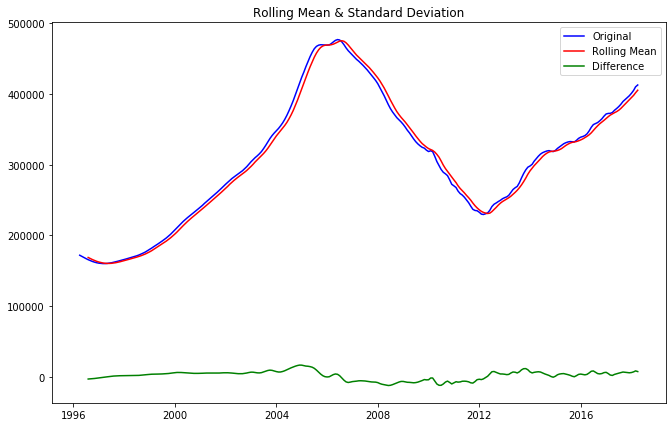

Results of Dickey-Fuller Test: 95949 

Test Statistic                  -3.601986
p-value                          0.005723
#Lags Used                      16.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64 



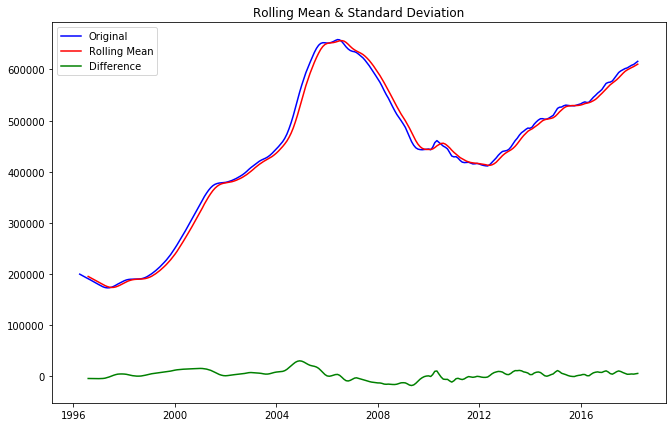

Results of Dickey-Fuller Test: 96161 

Test Statistic                  -4.225134
p-value                          0.000597
#Lags Used                      14.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64 



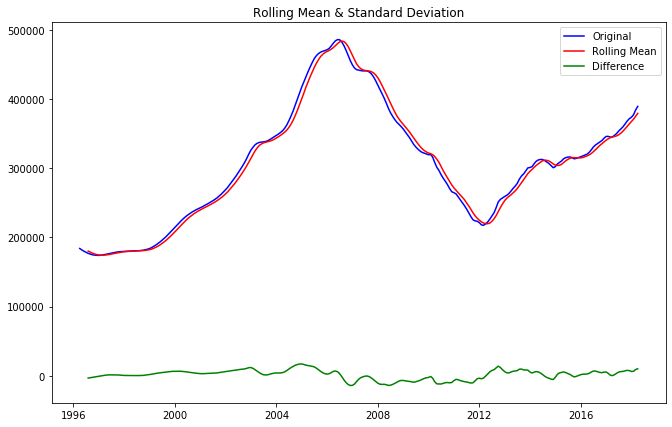

Results of Dickey-Fuller Test: 95946 

Test Statistic                  -4.016041
p-value                          0.001329
#Lags Used                      14.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64 



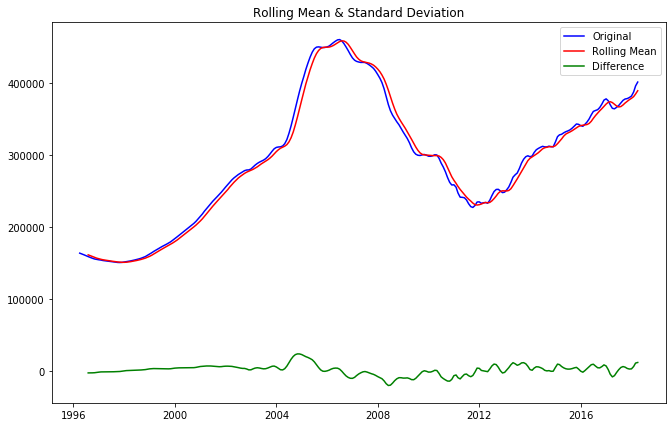

Results of Dickey-Fuller Test: 95975 

Test Statistic                  -4.352079
p-value                          0.000360
#Lags Used                      14.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64 



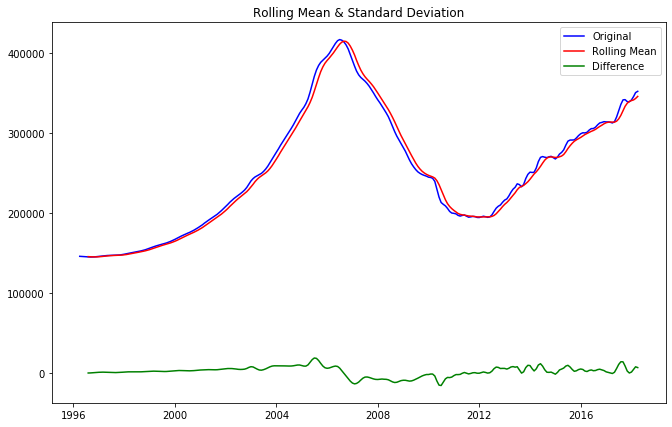

Results of Dickey-Fuller Test: 95977 

Test Statistic                  -5.060496
p-value                          0.000017
#Lags Used                      10.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64 



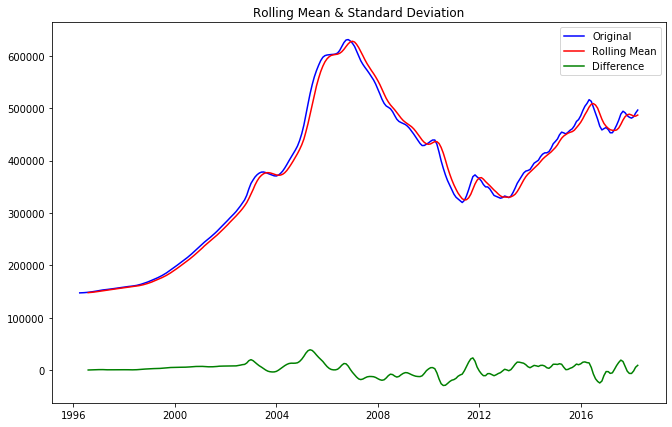

Results of Dickey-Fuller Test: 95728 

Test Statistic                -5.912942e+00
p-value                        2.612822e-07
#Lags Used                     1.300000e+01
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64 



In [182]:
for x, y in zip(zip_dfs, zips):
    roll_mean = x.rolling(window=5).mean()
    data_minus_roll_mean = x - roll_mean 
    data_diff = data_minus_roll_mean.diff(periods=1)
    data_diff.dropna(inplace=True)
    fig = plt.figure(figsize=(11,7))
    plt.plot(x, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(data_minus_roll_mean, color='green', label='Difference')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    data_minus_roll_mean = pd.DataFrame(data_minus_roll_mean)
    dickey_fuller(data_diff, y)

In [48]:
def stationary_series(x,y):
    roll_mean = x.rolling(window=5).mean()
    data_minus_roll_mean = x - roll_mean 
    data_diff = data_minus_roll_mean.diff(periods=1)
    data_diff.dropna(inplace=True)
    fig = plt.figure(figsize=(11,7))
    plt.plot(x, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(data_minus_roll_mean, color='green', label='Difference')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    dickey_fuller(data_diff, y)
    return data_diff

In [49]:
zips

array([95945, 95959, 95949, 96161, 95946, 95975, 95977, 95728],
      dtype=int64)

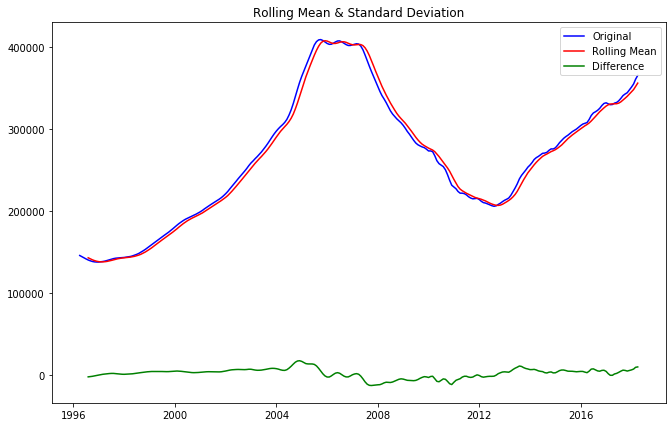

Results of Dickey-Fuller Test: 95945 

Test Statistic                  -4.112540
p-value                          0.000923
#Lags Used                      16.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64 



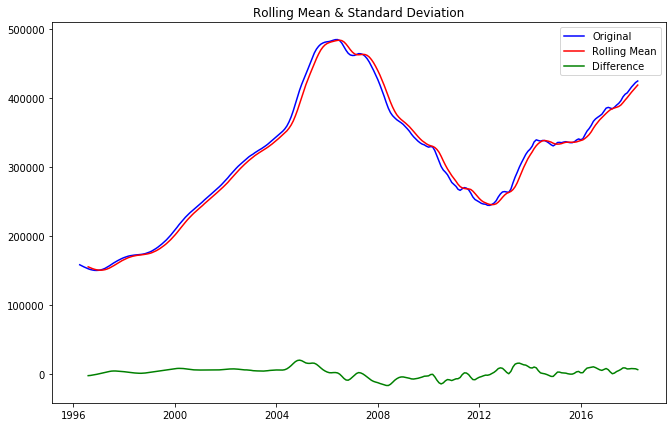

Results of Dickey-Fuller Test: 95959 

Test Statistic                  -4.688955
p-value                          0.000088
#Lags Used                      13.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64 



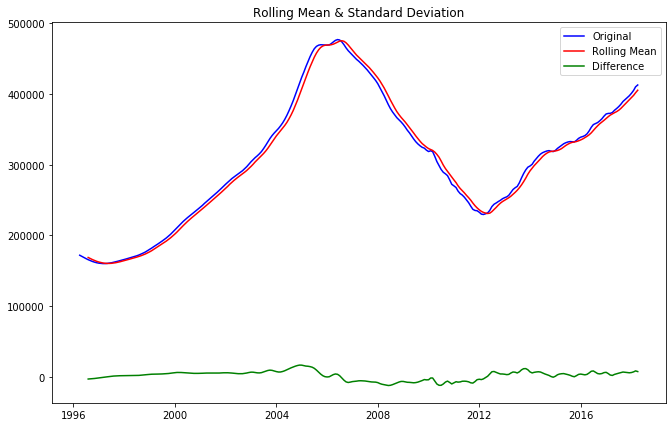

Results of Dickey-Fuller Test: 95949 

Test Statistic                  -3.601986
p-value                          0.005723
#Lags Used                      16.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64 



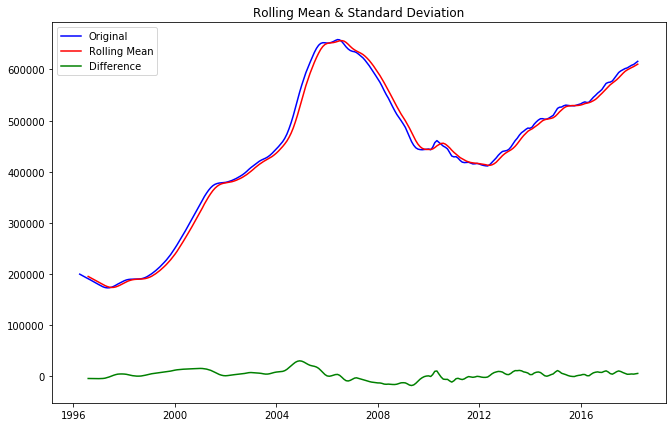

Results of Dickey-Fuller Test: 96161 

Test Statistic                  -4.225134
p-value                          0.000597
#Lags Used                      14.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64 



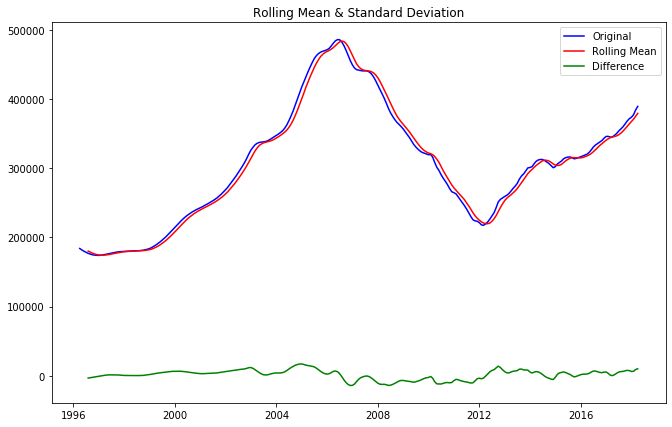

Results of Dickey-Fuller Test: 95946 

Test Statistic                  -4.016041
p-value                          0.001329
#Lags Used                      14.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64 



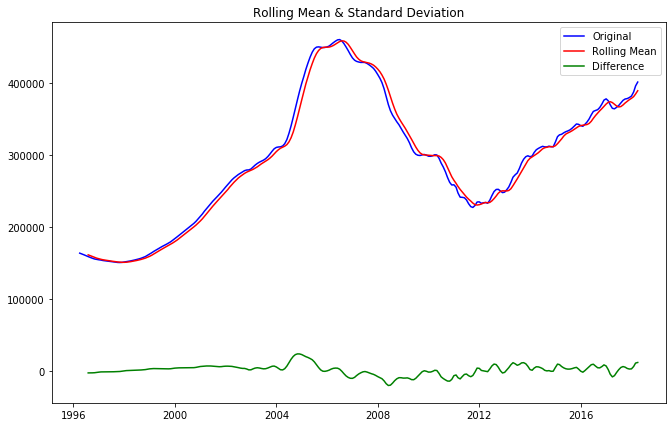

Results of Dickey-Fuller Test: 95975 

Test Statistic                  -4.352079
p-value                          0.000360
#Lags Used                      14.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64 



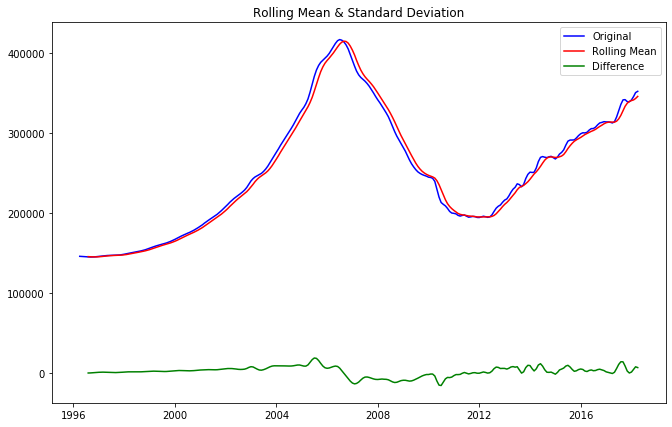

Results of Dickey-Fuller Test: 95977 

Test Statistic                  -5.060496
p-value                          0.000017
#Lags Used                      10.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64 



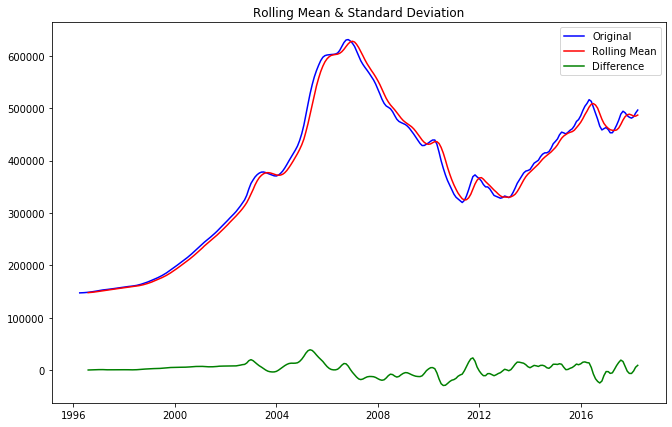

Results of Dickey-Fuller Test: 95728 

Test Statistic                -5.912942e+00
p-value                        2.612822e-07
#Lags Used                     1.300000e+01
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64 



In [50]:
sta_zip_95945 = stationary_series(zip_95945, 95945)
sta_zip_95959 = stationary_series(zip_95959, 95959)
sta_zip_95949 = stationary_series(zip_95949, 95949)
sta_zip_96161 = stationary_series(zip_96161, 96161)
sta_zip_95946 = stationary_series(zip_95946, 95946)
sta_zip_95975 = stationary_series(zip_95975, 95975)
sta_zip_95977 = stationary_series(zip_95977, 95977)
sta_zip_95728 = stationary_series(zip_95728, 95728)

## Decomposition

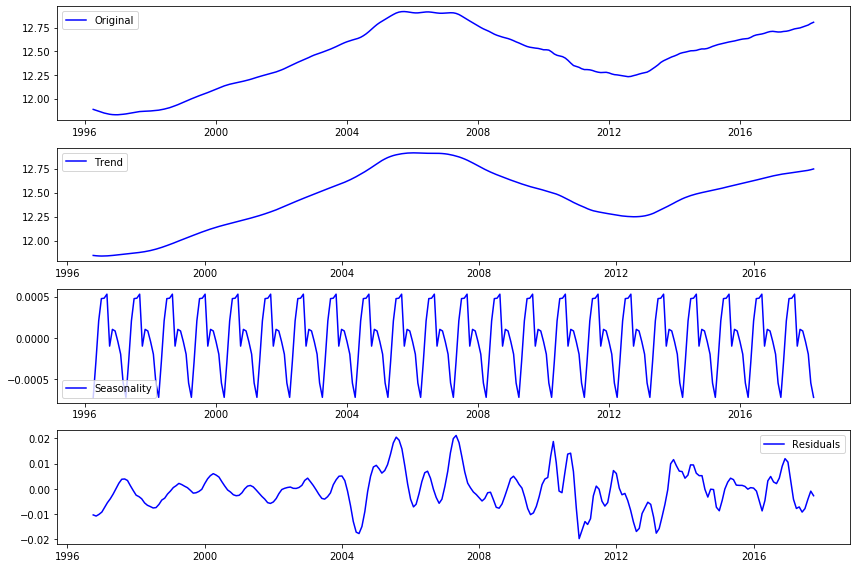

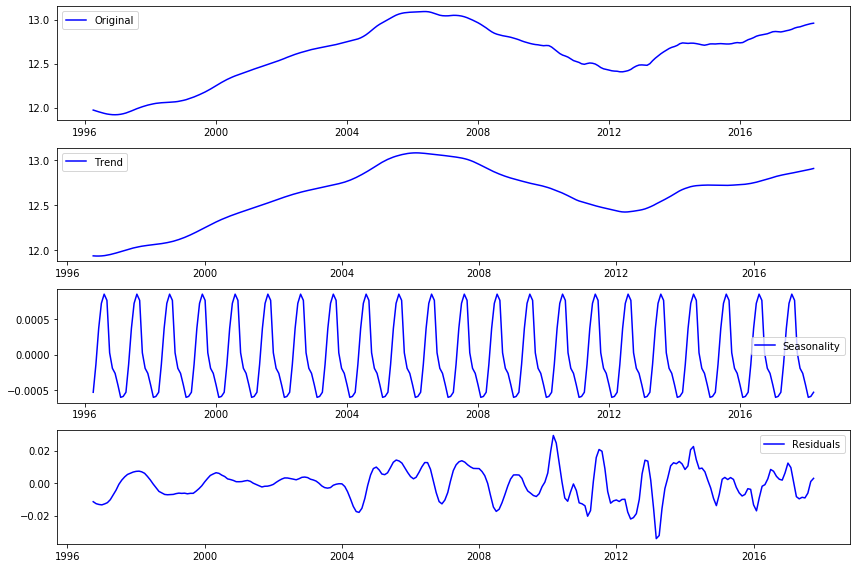

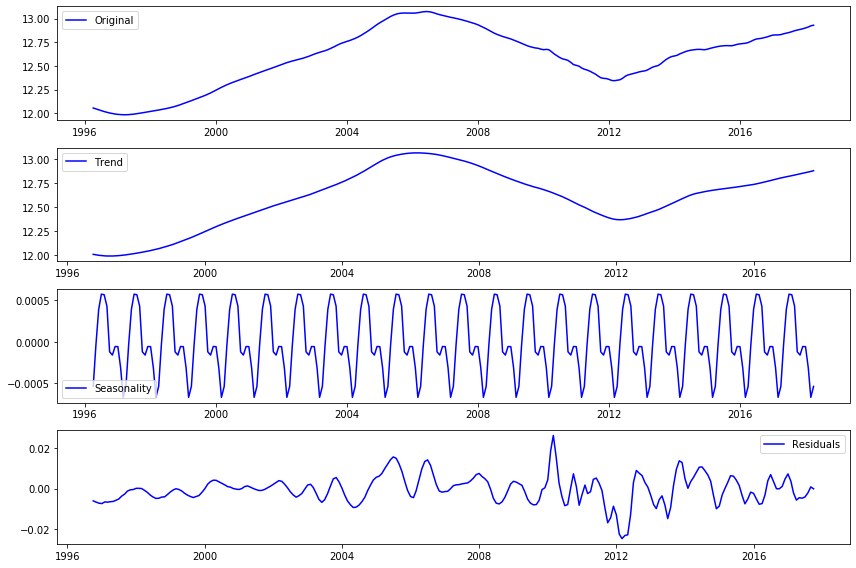

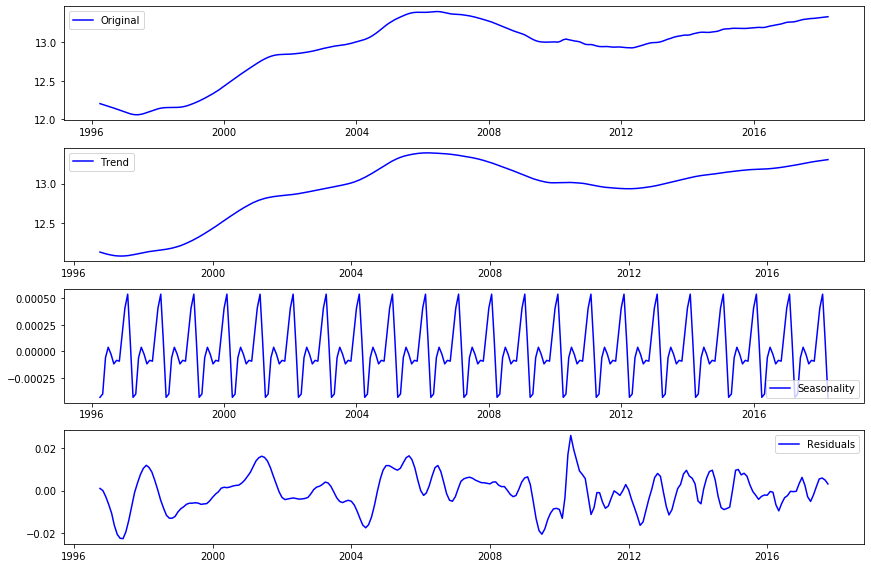

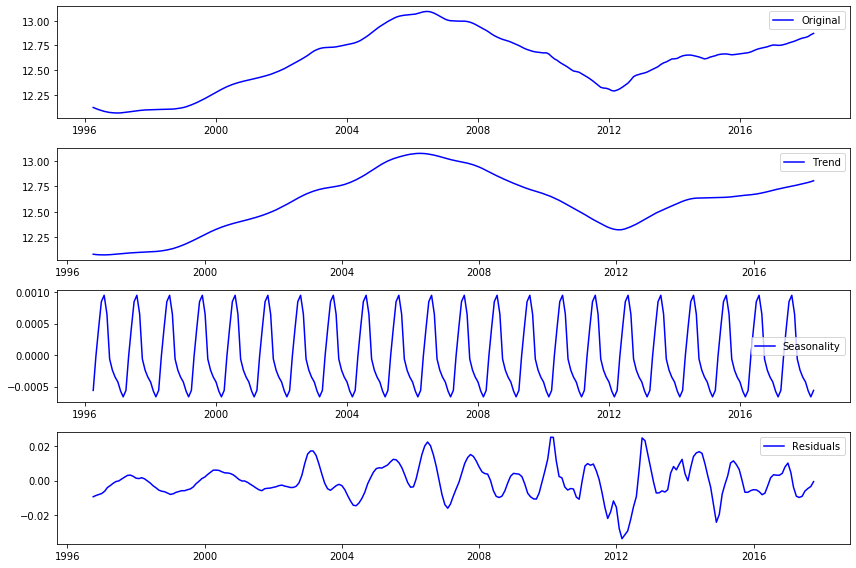

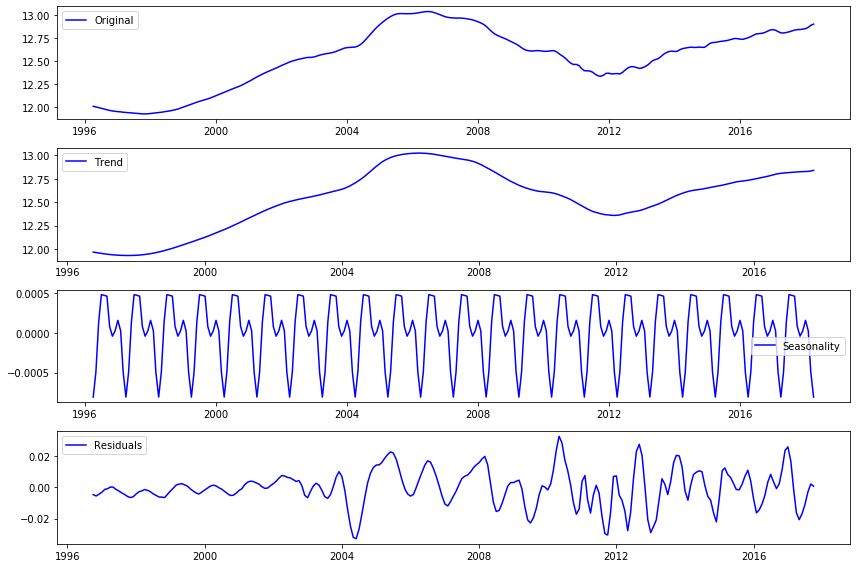

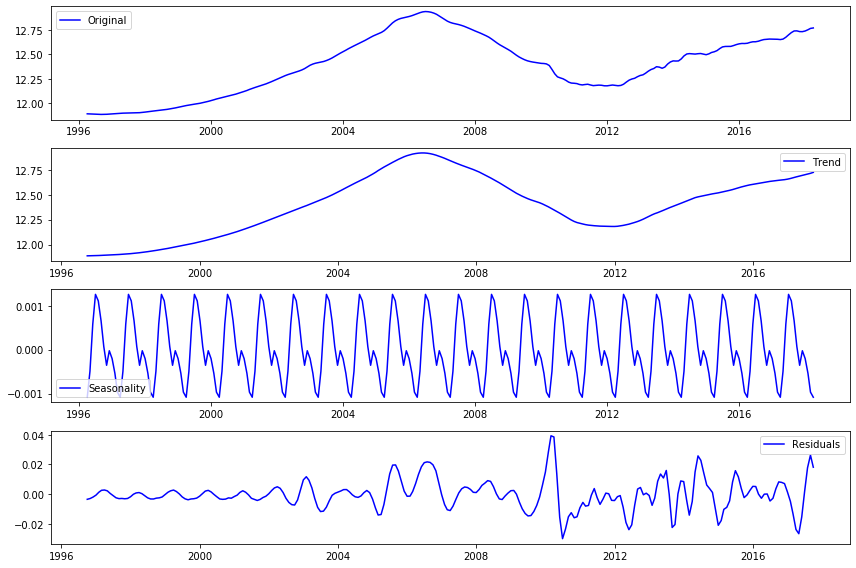

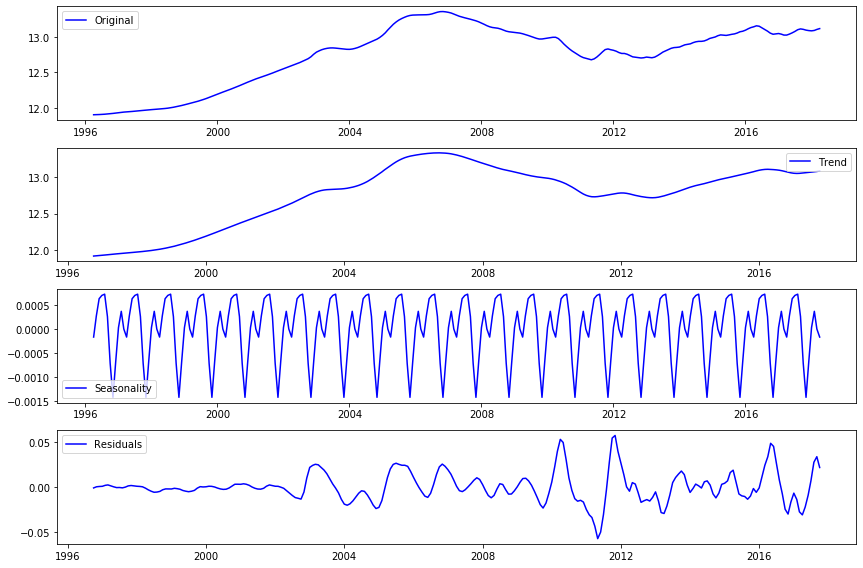

In [324]:
list = []
for x,y in zip(zip_dfs, zips):
    
    
    decomposition = seasonal_decompose(np.log(x))

    # trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot 
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(x), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show();
    
    list.append(residual)

In [325]:
for i in list:
    i.dropna(inplace=True)
    i = pd.DataFrame(i)

In [327]:
res_zip_95945 = list[0]
res_zip_95959 = list[1]
res_zip_95949 = list[2]
res_zip_96161 = list[3]
res_zip_95946 = list[4]
res_zip_95975 = list[5]
res_zip_95977 = list[6]
res_zip_95728 = list[7]

In [328]:
print (f'Results of Dickey-Fuller Test: 95728 \n')
dftest = adfuller(res_zip_95728)


dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(f'{dfoutput} \n')

Results of Dickey-Fuller Test: 95728 

Test Statistic                  -4.544573
p-value                          0.000163
#Lags Used                      14.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64 



## PACF ACF

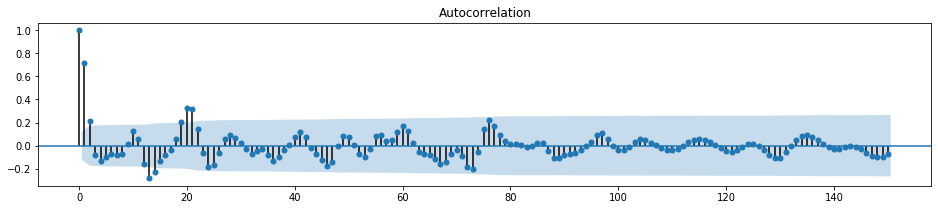

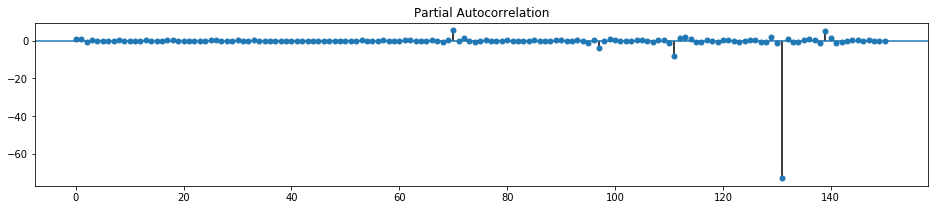

In [56]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(sta_zip_95945, ax=ax, lags=150);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(sta_zip_95945, ax=ax, lags=150);

## Theta Forcaster Model

In [ ]:
 y = zip_96161.copy()
    y = y.reset_index()
    y = y.drop('Date', axis=1)
    y = y.Value
    y_train, y_test = temporal_train_test_split(y, test_size=0.28)
    y_train

In [246]:
fh = np.arange(1, len(y_test) + 1)  # forecasting horizon 1 - length of test size
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75])

In [221]:
forecaster = ThetaForecaster(sp=1)  # monthly seasonal periodicity
forecaster.fit(y_train.reset_index()['Value'])
type(y_train)

pandas.core.frame.DataFrame

In [211]:
y_preds = forecaster.predict(fh)
type(y_preds)

pandas.core.series.Series

In [212]:
y_test['preds'] = y_preds.values
y_test.head()

,Value,preds
Date,,
2012-02-01,211300.0,214611.699231
2012-03-01,209800.0,215117.548846
2012-04-01,209200.0,215623.398461
2012-05-01,208200.0,216129.248077
2012-06-01,207100.0,216635.097692


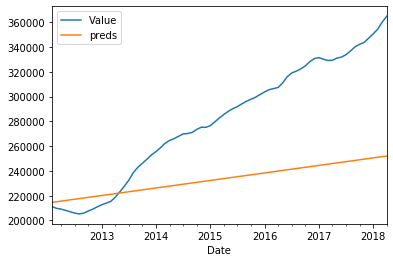

In [213]:
y_test.plot()
plt.show()

This model didnt accurately predict the test values even using various parameters.

## Final Model

0.03404712562185295
Estimated Return: $116000.0
95945
0.06486763487378011
Estimated Return: $156600.0
95959
0.029631391237731636
Estimated Return: $135600.0
95949
0.09118269553018633
Estimated Return: $283700.0
96161
0.07375483197410748
Estimated Return: $145000.0
95946
0.037969315439119654
Estimated Return: $146400.0
95975
0.08890890623922205
Estimated Return: $116100.0
95977
0.06234453821276686
Estimated Return: $320700.0
95728


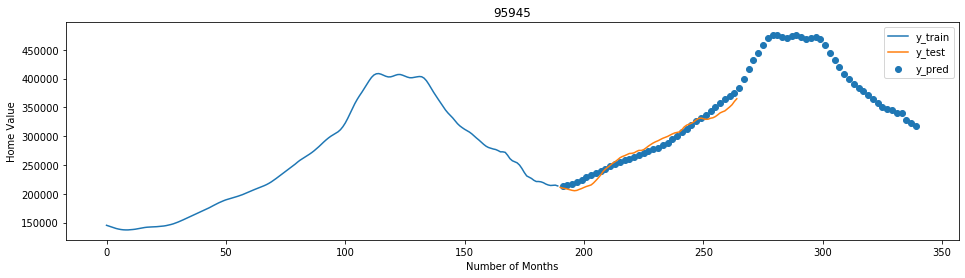

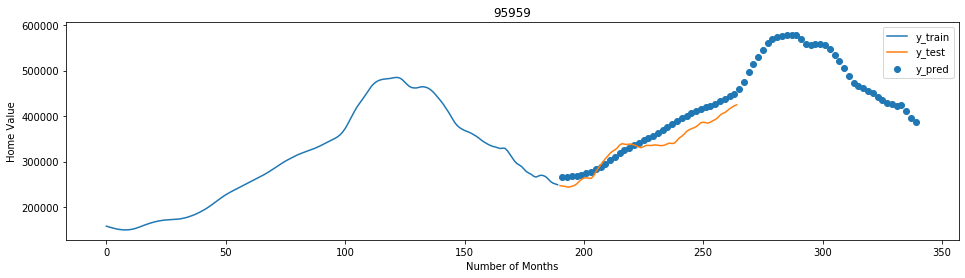

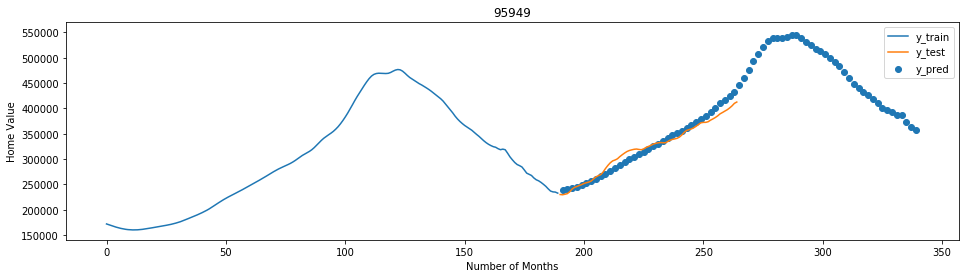

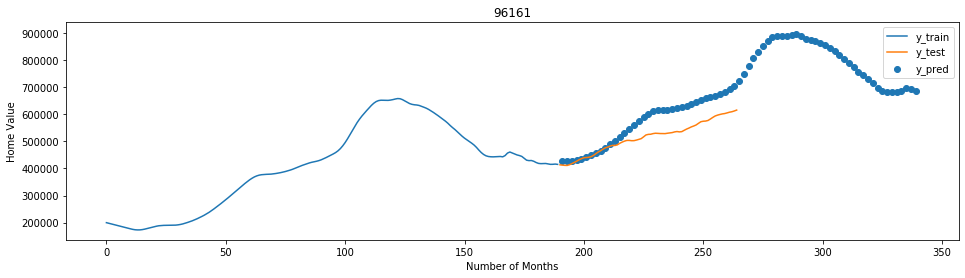

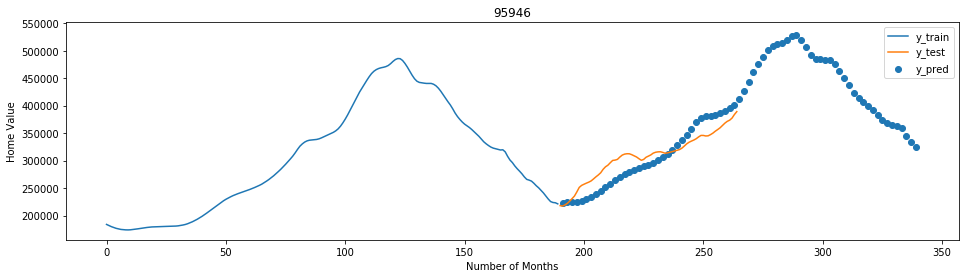

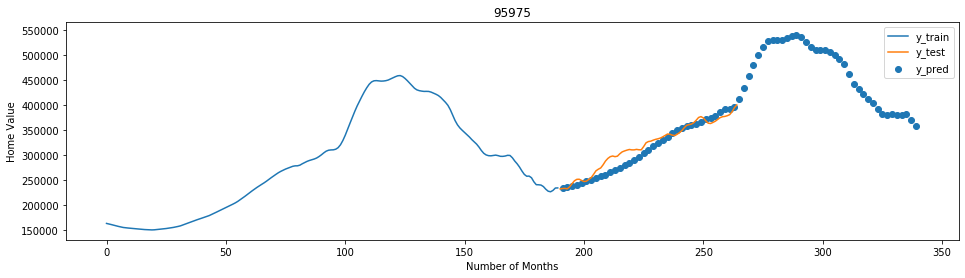

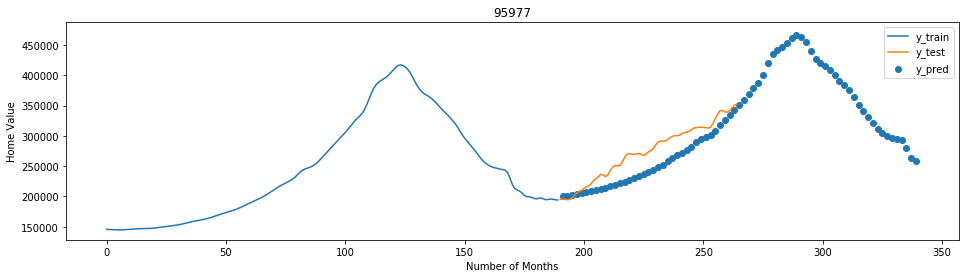

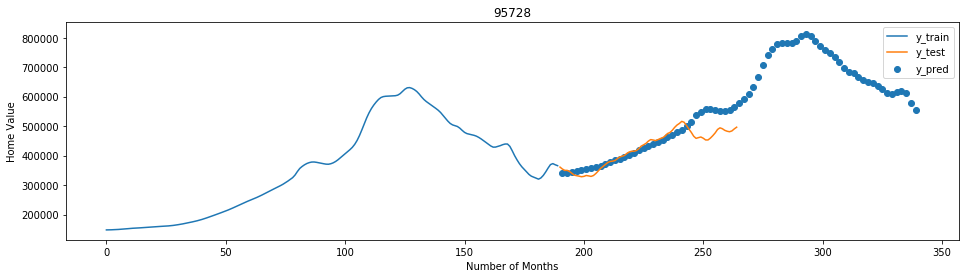

In [391]:
returns = []

for x,z in zip(zip_dfs, zips):    
    y = x.copy()
    y = y.reset_index()
    y = y.drop('Date', axis=1)
    y = y.Value
    y_train, y_test = temporal_train_test_split(y, test_size=0.28)
    y_train

    forecaster = NaiveForecaster(strategy="seasonal_last", sp=166)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    y_pred2 = forecaster.predict(fh+fh)
    y_pred = y_pred + (y_test.min() - y_train.min())
    y_pred2 = y_pred2 + (y_test.min() - y_train.min())
    fig, ax = plot_ys(y_train, y_test, y_pred2, labels=["y_train", "y_test", "y_pred"])
    ax.set(xlabel='Number of Months', ylabel='Home Value')
    ax.set_title(z)
    print(smape_loss(y_pred, y_test))
    print(f'Estimated Return: ${y_pred2.max() - y_test[263]}')
    returns.append(y_pred2.max() - y_test[263])
    print(z)

In [347]:
returns = pd.Series(returns)

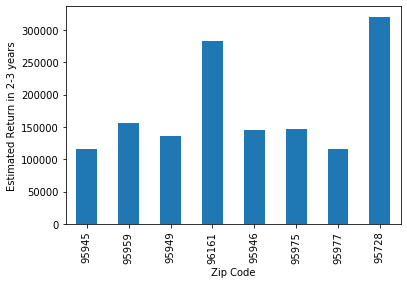

In [388]:
returns.plot(kind='bar')
plt.xticks([0,1,2,3,4,5,6,7], [95945, 95959, 95949, 96161, 95946, 95975, 95977, 95728])
plt.ylabel('Estimated Return in 2-3 years');
plt.xlabel('Zip Code');

## Result

Homes in zip code 95728 are the likely to be the best investment in this county.  Returns are expected to be around $320,700 if purchased now and then sold at the next economic peak. The next peak is expected to occur in about 2-3 years. All zip codes in this county are in an upward trend, so any purchase here would still very likely be profitable. 